Please upload your 'transaction_dataset.csv' file


Saving transaction_dataset.csv to transaction_dataset.csv
Dataset shape: (9841, 51)
Class distribution:
 FLAG
0    0.778579
1    0.221421
Name: proportion, dtype: float64
Missing values after preprocessing: 0
Train shape: (7872, 47) | Test shape: (1969, 47)
Applying SMOTE...
After SMOTE - class distribution:
 FLAG
0    0.5
1    0.5
Name: proportion, dtype: float64
Training XGBoost...

Classification Report
              precision    recall  f1-score   support

           0     0.9935    0.9987    0.9961      1533
           1     0.9953    0.9771    0.9861       436

    accuracy                         0.9939      1969
   macro avg     0.9944    0.9879    0.9911      1969
weighted avg     0.9939    0.9939    0.9939      1969


AUC-ROC: 0.9989


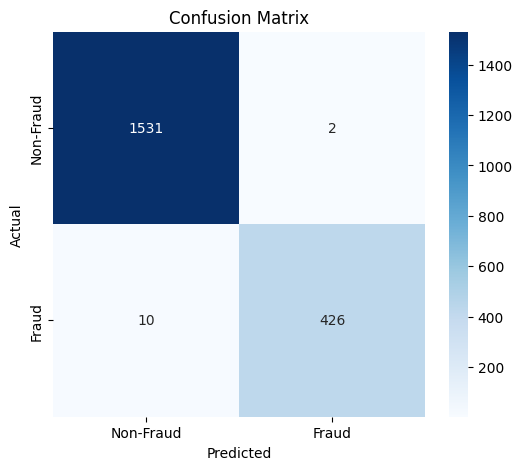


Top 15 Features:
                                              feature  importance
22                                   Total ERC20 tnxs    0.352091
2             Time Diff between first and last (Mins)    0.170428
46                          ERC20_most_rec_token_type    0.108656
45                         ERC20 most sent token type    0.084597
11                                       min val sent    0.018843
1                        Avg min between received tnx    0.018666
17  total transactions (including tnx to create co...    0.018188
6                      Unique Received From Addresses    0.017574
19                               total ether received    0.014791
43                         ERC20 uniq sent token name    0.014571
24                             ERC20 total ether sent    0.013746
26                               ERC20 uniq sent addr    0.013679
27                                ERC20 uniq rec addr    0.013380
9                                 max value received     0

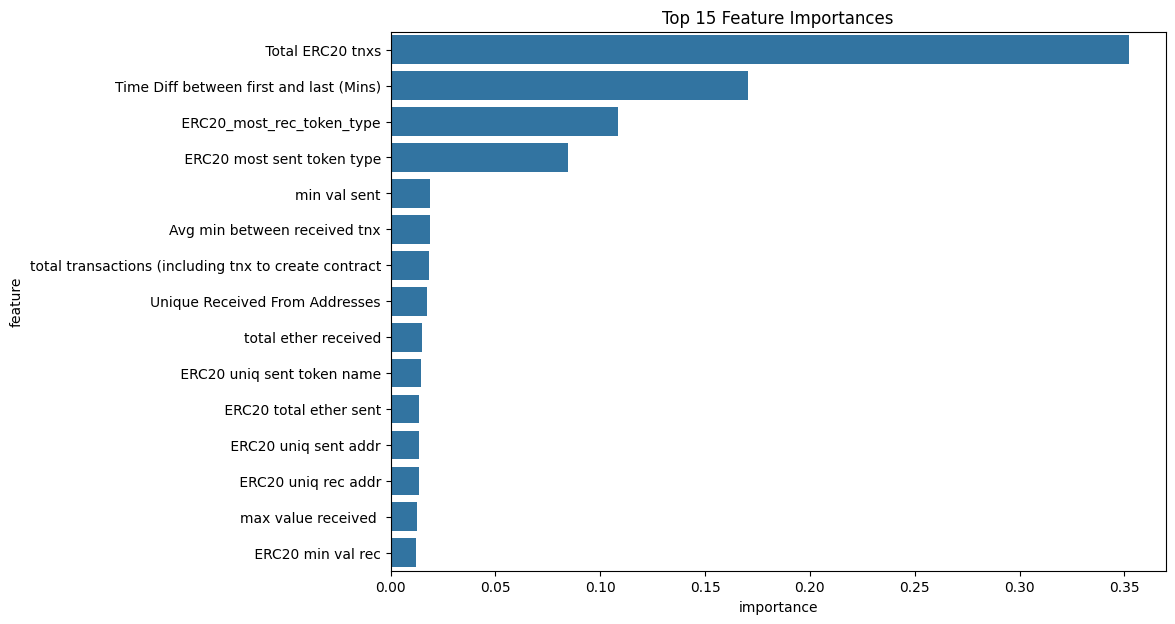

Model saved as: eth_fraud_xgb.json


In [1]:
# ────────────────────────────────────────────────────────────────
# Ethereum Fraud Detection - XGBoost Model (Google Colab Version)
# ────────────────────────────────────────────────────────────────

# 1. Install required packages (if not already available)
!pip install -q xgboost imbalanced-learn

# 2. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ────────────────────────────────────────────────────────────────
# STEP 1: Upload your dataset
# ────────────────────────────────────────────────────────────────
print("Please upload your 'transaction_dataset.csv' file")
uploaded = files.upload()

# Load the file (assumes you uploaded exactly one file)
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, low_memory=False)

print("Dataset shape:", df.shape)
print("Class distribution:\n", df['FLAG'].value_counts(normalize=True))

# ────────────────────────────────────────────────────────────────
# STEP 2: Basic cleaning & feature preparation
# ────────────────────────────────────────────────────────────────

# Drop columns that are not useful for modeling
drop_cols = ['Index', 'Address']
if 'Unnamed: 0' in df.columns:
    drop_cols.append('Unnamed: 0')

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Target
y = df['FLAG'].copy()
X = df.drop(columns=['FLAG'])

# ────────────────────────────────────────────────────────────────
# Handle categorical columns (mainly ERC20 token names)
# ────────────────────────────────────────────────────────────────
cat_cols = [
    ' ERC20 most sent token type',
    ' ERC20_most_rec_token_name',           # typo in your header?
    ' ERC20_most_rec_token_type'
]

# Fix possible typos in column names (your dataset has inconsistencies)
real_cat_cols = [c for c in cat_cols if c in X.columns] + \
                [' ERC20 most sent token type', ' ERC20_most_rec_token_type']

for col in real_cat_cols:
    if col in X.columns:
        X[col] = X[col].fillna('None').astype(str)

# Label encode categorical features
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# ────────────────────────────────────────────────────────────────
# Handle numerical missing values
# ────────────────────────────────────────────────────────────────
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

print("Missing values after preprocessing:", X.isna().sum().sum())

# ────────────────────────────────────────────────────────────────
# STEP 3: Scale numerical features
# ────────────────────────────────────────────────────────────────
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# ────────────────────────────────────────────────────────────────
# STEP 4: Train / Test split
# ────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

# ────────────────────────────────────────────────────────────────
# STEP 5: Apply SMOTE (handle class imbalance)
# ────────────────────────────────────────────────────────────────
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE - class distribution:\n", pd.Series(y_train_res).value_counts(normalize=True))

# ────────────────────────────────────────────────────────────────
# STEP 6: Train XGBoost
# ────────────────────────────────────────────────────────────────
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("Training XGBoost...")
model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# ────────────────────────────────────────────────────────────────
# STEP 7: Evaluate
# ────────────────────────────────────────────────────────────────
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(y_test, y_pred, digits=4))

print("\nAUC-ROC:", round(roc_auc_score(y_test, y_pred_proba), 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ────────────────────────────────────────────────────────────────
# STEP 8: Feature Importance (Top 15)
# ────────────────────────────────────────────────────────────────
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Features:")
print(importance.head(15))

plt.figure(figsize=(10,7))
sns.barplot(data=importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances')
plt.show()

# ────────────────────────────────────────────────────────────────
# Optional: Save model
# ────────────────────────────────────────────────────────────────

model.save_model("eth_fraud_xgb.json")
print("Model saved as: eth_fraud_xgb.json")

In [2]:
import pickle

# Save model
model.save_model("eth_fraud_xgb.json")

# Save preprocessors
preprocessors = {
    "scaler": scaler,
    "label_encoders": label_encoders,
}
with open("preprocessors.pkl", "wb") as f:
    pickle.dump(preprocessors, f)

# Download both files
from google.colab import files
files.download("eth_fraud_xgb.json")
files.download("preprocessors.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Install SHAP (run once)
!pip install -q shap

import shap
import pandas as pd

# Create explainer (works great with XGBoost)
explainer = shap.TreeExplainer(model)

# Compute SHAP values on the test set (or on new predictions later)
shap_values = explainer.shap_values(X_test)

# ────────────────────────────────────────────────────────────────
# Function to generate human-readable reason (the magic part)
# ────────────────────────────────────────────────────────────────
def explain_prediction(idx, prob_threshold=0.25):
    prob = model.predict_proba(X_test.iloc[[idx]])[0, 1]
    if prob < prob_threshold:
        return "Not flagged as fraud"

    # Get top 5 contributing features for this instance
    shap_vals = pd.Series(shap_values[idx], index=X.columns).abs().sort_values(ascending=False)
    top_features = shap_vals.head(5).index.tolist()

    reasons = []
    for feat in top_features:
        val = X_test.iloc[idx][feat]
        if "ERC20" in feat or "token" in feat.lower():
            reasons.append(f"• Unusual ERC20/token activity ({feat})")
        elif "time" in feat.lower() or "diff" in feat.lower():
            reasons.append(f"• Very short account lifetime or rapid activity ({feat})")
        elif "uniq" in feat.lower() or "unique" in feat.lower():
            reasons.append(f"• Many different counterparties ({feat})")
        elif "val" in feat.lower() or "ether" in feat.lower():
            reasons.append(f"• Large or unusual value transfers ({feat})")
        else:
            reasons.append(f"• High value in feature: {feat}")

    explanation = "Flagged as fraud because:\n" + "\n".join(reasons[:5])
    return explanation + f"\n\nFraud probability: {prob:.1%}"

# Example usage
print(explain_prediction(0))        # change index to see different addresses

Flagged as fraud because:
• Unusual ERC20/token activity ( ERC20_most_rec_token_type)
• Unusual ERC20/token activity ( Total ERC20 tnxs)
• Very short account lifetime or rapid activity (Time Diff between first and last (Mins))
• Many different counterparties (Unique Received From Addresses)
• Unusual ERC20/token activity ( ERC20 most sent token type)

Fraud probability: 100.0%


0: Flagged as fraud because:

- Unusual ERC20/token activity ( ERC20_most_rec_token_type)
- Unusual ERC20/token activity ( Total ERC20 tnxs)
- Very short account lifetime or rapid activity (Time Diff between first and last (Mins))
- Many different counterparties (Unique Received From Addresses)
- Unusual ERC20/token activity ( ERC20 most sent token type)
Fraud probability: 100.0%

17:
Flagged as fraud because:
- Unusual ERC20/token activity ( ERC20 most sent token type)
- Many different counterparties (Unique Received From Addresses)
- Very short account lifetime or rapid activity (Time Diff between first and last (Mins))
- Large or unusual value transfers (avg val received)
- Unusual ERC20/token activity ( Total ERC20 tnxs)
Fraud probability: 100.0%

20:
Flagged as fraud because:

- Unusual ERC20/token activity ( ERC20_most_rec_token_type)
- Unusual ERC20/token activity ( Total ERC20 tnxs)
- Very short account lifetime or rapid activity (Time Diff between first and last (Mins))
- Many different counterparties (Unique Received From Addresses)
- Unusual ERC20/token activity ( ERC20 most sent token type)
Fraud probability: 100.0%

In [4]:
X_test.head(10)

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
9631,-0.236759,-0.346822,-0.676119,-0.153108,-0.174004,-0.02637,-0.101676,-0.097951,-0.134530,-0.040217,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.219087,1.135814,1.136226
2950,-0.235723,-0.346822,-0.675912,-0.149146,-0.172941,-0.02637,-0.098327,-0.086579,0.175369,-0.032453,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.281606,-0.801914,-0.879806
6233,-0.236759,1.098114,-0.056465,-0.153108,-0.167626,-0.01930,-0.094978,-0.097951,-0.134530,-0.037911,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.094049,1.135814,-0.579110
6164,-0.015172,3.792764,1.158095,-0.147826,-0.167626,-0.02637,-0.084931,-0.090370,-0.134500,-0.034635,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,0.718699,1.135814,1.395918
8573,-0.165756,1.152405,0.214199,-0.143864,-0.165500,-0.02637,-0.078233,-0.071416,-0.134512,-0.040075,...,-0.010665,-0.010285,-0.009989,0.0,0.0,0.0,0.268224,-0.031530,1.371339,2.174995
302,-0.236566,0.021061,-0.623505,-0.150467,-0.171878,-0.02637,-0.094978,-0.090370,-0.134354,-0.040155,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.281606,-0.801914,-0.879806
7841,-0.236759,-0.346822,-0.660774,-0.151788,-0.172941,-0.02637,-0.098327,-0.094160,-0.131462,-0.040140,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.219087,-0.834031,-0.394592
606,-0.236759,-0.253257,0.026071,-0.153108,-0.062395,-0.01930,-0.094978,-0.097951,-0.134530,-0.040173,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.156568,1.135814,-0.087062
253,-0.138823,-0.111883,-0.622986,-0.149146,-0.171878,-0.02637,-0.094978,-0.086579,-0.134332,-0.040207,...,-0.010540,-0.010573,-0.010223,0.0,0.0,0.0,-0.041551,-0.219087,0.472062,0.480161
4973,-0.236123,-0.346822,-0.675992,-0.149146,-0.172941,-0.02637,-0.098327,-0.086579,0.175369,-0.032453,...,-0.010665,-0.010573,-0.010223,0.0,0.0,0.0,-0.196438,-0.281606,-0.801914,-0.879806


In [5]:
df.FLAG == 1

,FLAG
0,False
1,False
2,False
3,False
4,False
...,...
9836,True
9837,True
9838,True
9839,True


In [6]:
# ────────────────────────────────────────────────────────────────
# List all features used in the Ethereum fraud model
# ────────────────────────────────────────────────────────────────

import pandas as pd
from google.colab import files

# Upload your dataset (only needed once)
print("Upload transaction_dataset.csv if you haven't already")
uploaded = files.upload()

# Load the file
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, low_memory=False)

# ────────────────────────────────────────────────────────────────
# Columns we drop / ignore (same as in training)
# ────────────────────────────────────────────────────────────────
ignore_cols = ['FLAG', 'Index', 'Address']
if 'Unnamed: 0' in df.columns:
    ignore_cols.append('Unnamed: 0')

# All modeling features
features = [col for col in df.columns if col not in ignore_cols]

print(f"Total features used by the model: {len(features)}\n")

# ────────────────────────────────────────────────────────────────
# Group features logically (helps when thinking about data sources)
# ────────────────────────────────────────────────────────────────

groups = {
    "Basic account activity": [
        "Avg min between sent tnx",
        "Avg min between received tnx",
        "Time Diff between first and last (Mins)",
        "Sent tnx",
        "Received Tnx",
        "total transactions (including tnx to create contract",
        "Number of Created Contracts",
    ],
    "Counterparty diversity": [
        "Unique Received From Addresses",
        "Unique Sent To Addresses",
    ],
    "Ether value statistics (ETH)": [
        "min value received", "max value received", "avg val received",
        "min val sent", "max val sent", "avg val sent",
        "total Ether sent", "total ether received",
        "total ether balance",
    ],
    "Contract interaction (ETH)": [
        "min value sent to contract", "max value sent to contract", "avg value sent to contract",
        "total ether sent contracts",
    ],
    "ERC-20 / Token activity": [
        "Total ERC20 tnxs",
        "ERC20 total Ether received", "ERC20 total ether sent", "ERC20 total Ether sent contract",
        "ERC20 uniq sent addr", "ERC20 uniq rec addr",
        "ERC20 uniq sent addr.1", "ERC20 uniq rec contract addr",
        "ERC20 avg time between sent tnx", "ERC20 avg time between rec tnx",
        "ERC20 avg time between rec 2 tnx", "ERC20 avg time between contract tnx",
        "ERC20 min val rec", "ERC20 max val rec", "ERC20 avg val rec",
        "ERC20 min val sent", "ERC20 max val sent", "ERC20 avg val sent",
        "ERC20 min val sent contract", "ERC20 max val sent contract", "ERC20 avg val sent contract",
        "ERC20 uniq sent token name", "ERC20 uniq rec token name",
        "ERC20 most sent token type", "ERC20_most_rec_token_type",
    ]
}

# Print grouped view
for group_name, cols in groups.items():
    found = [c for c in cols if c in features]
    if found:
        print(f"┌─ {group_name} ({len(found)} features)")
        for col in sorted(found):
            print(f"│  • {col}")
        print("└───────────────────────────────────────\n")

# ────────────────────────────────────────────────────────────────
# Show which features are categorical vs numerical
# ────────────────────────────────────────────────────────────────
cat_features = df[features].select_dtypes(include=['object', 'category']).columns.tolist()
num_features = df[features].select_dtypes(include=['number', 'float64', 'int64']).columns.tolist()

print("Categorical features (need label encoding or similar):")
print(",\n".join(f"  • {c}" for c in sorted(cat_features)) or "  (none)")
print("\nNumerical features:")
print(",\n".join(f"  • {c}" for c in sorted(num_features)))

print(f"\nTotal categorical: {len(cat_features)}")
print(f"Total numerical:   {len(num_features)}")

Upload transaction_dataset.csv if you haven't already


Saving transaction_dataset.csv to transaction_dataset (1).csv
Total features used by the model: 47

┌─ Basic account activity (7 features)
│  • Avg min between received tnx
│  • Avg min between sent tnx
│  • Number of Created Contracts
│  • Received Tnx
│  • Sent tnx
│  • Time Diff between first and last (Mins)
│  • total transactions (including tnx to create contract
└───────────────────────────────────────

┌─ Counterparty diversity (2 features)
│  • Unique Received From Addresses
│  • Unique Sent To Addresses
└───────────────────────────────────────

┌─ Ether value statistics (ETH) (8 features)
│  • avg val received
│  • avg val sent
│  • max val sent
│  • min val sent
│  • min value received
│  • total Ether sent
│  • total ether balance
│  • total ether received
└───────────────────────────────────────

┌─ Contract interaction (ETH) (3 features)
│  • avg value sent to contract
│  • min value sent to contract
│  • total ether sent contracts
└───────────────────────────────────────


Total features used by the model: 47

┌─ Basic account activity (7 features)
│  • Avg min between received tnx
│  • Avg min between sent tnx
│  • Number of Created Contracts
│  • Received Tnx
│  • Sent tnx
│  • Time Diff between first and last (Mins)
│  • total transactions (including tnx to create contract
└───────────────────────────────────────

┌─ Counterparty diversity (2 features)
│  • Unique Received From Addresses
│  • Unique Sent To Addresses
└───────────────────────────────────────

┌─ Ether value statistics (ETH) (8 features)
│  • avg val received
│  • avg val sent
│  • max val sent
│  • min val sent
│  • min value received
│  • total Ether sent
│  • total ether balance
│  • total ether received
└───────────────────────────────────────

┌─ Contract interaction (ETH) (3 features)
│  • avg value sent to contract
│  • min value sent to contract
│  • total ether sent contracts
└───────────────────────────────────────

Categorical features (need label encoding or similar):
  •  ERC20 most sent token type,
  •  ERC20_most_rec_token_type

Numerical features:
  •  ERC20 avg time between contract tnx,
  •  ERC20 avg time between rec 2 tnx,
  •  ERC20 avg time between rec tnx,
  •  ERC20 avg time between sent tnx,
  •  ERC20 avg val rec,
  •  ERC20 avg val sent,
  •  ERC20 avg val sent contract,
  •  ERC20 max val rec,
  •  ERC20 max val sent,
  •  ERC20 max val sent contract,
  •  ERC20 min val rec,
  •  ERC20 min val sent,
  •  ERC20 min val sent contract,
  •  ERC20 total Ether received,
  •  ERC20 total Ether sent contract,
  •  ERC20 total ether sent,
  •  ERC20 uniq rec addr,
  •  ERC20 uniq rec contract addr,
  •  ERC20 uniq rec token name,
  •  ERC20 uniq sent addr,
  •  ERC20 uniq sent addr.1,
  •  ERC20 uniq sent token name,
  •  Total ERC20 tnxs,
  • Avg min between received tnx,
  • Avg min between sent tnx,
  • Number of Created Contracts,
  • Received Tnx,
  • Sent tnx,
  • Time Diff between first and last (Mins),
  • Unique Received From Addresses,
  • Unique Sent To Addresses,
  • avg val received,
  • avg val sent,
  • avg value sent to contract,
  • max val sent,
  • max val sent to contract,
  • max value received ,
  • min val sent,
  • min value received,
  • min value sent to contract,
  • total Ether sent,
  • total ether balance,
  • total ether received,
  • total ether sent contracts,
  • total transactions (including tnx to create contract




Total categorical: 2
Total numerical:   45